In [19]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
import scipy.signal

import math
import cv2 as cv
from ipywidgets import interact
import base64
import html
import IPython

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


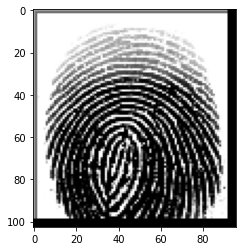

In [ ]:
def convolve_1d(array, kernel):
  ks = kernel.shape[0] # shape gives the dimensions of an array, as a tuple
  final_length = array.shape[0] - ks + 1
  return np.array([(array[i:i+ks]*kernel).sum() for i in range(final_length)])

def convolve_2d(array,kernel):
  ks = kernel.shape[1] # shape gives the dimensions of an array, as a tuple
  final_height = array.shape[1] - ks + 1
  return np.array([convolve_1d(array[:,i:i+ks],kernel) for i in range(final_height)]).T

p_msk=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
print(p_msk)
c=convolve_2d(img,p_msk)
plt.imshow()
# np.convolve(img,p_msk,'full')
# c=scipy.signal.convolve(img,p_msk,mode="valid")
# convolve(img, p_msk)

In [14]:
def show(*images, enlarge_small_images = True, max_per_row = -1, font_size = 0):
  if len(images) == 2 and type(images[1])==str:
      images = [(images[0], images[1])]

  def convert_for_display(img):
      if img.dtype!=np.uint8:
          a, b = img.min(), img.max()
          if a==b:
              offset, mult, d = 0, 0, 1
          elif a<0:
              offset, mult, d = 128, 127, max(abs(a), abs(b))
          else:
              offset, mult, d = 0, 255, b
          img = np.clip(offset + mult*(img.astype(float))/d, 0, 255).astype(np.uint8)
      return img

  def convert(imgOrTuple):
      try:
          img, title = imgOrTuple
          if type(title)!=str:
              img, title = imgOrTuple, ''
      except ValueError:
          img, title = imgOrTuple, ''        
      if type(img)==str:
          data = img
      else:
          img = convert_for_display(img)
          if enlarge_small_images:
              REF_SCALE = 100
              h, w = img.shape[:2]
              if h<REF_SCALE or w<REF_SCALE:
                  scale = max(1, min(REF_SCALE//h, REF_SCALE//w))
                  img = cv.resize(img,(w*scale,h*scale), interpolation=cv.INTER_NEAREST)
          data = 'data:image/png;base64,' + base64.b64encode(cv.imencode('.png', img)[1]).decode('utf8')
      return data, title
    
  if max_per_row == -1:
      max_per_row = len(images)

  rows = [images[x:x+max_per_row] for x in range(0, len(images), max_per_row)]
  font = f"font-size: {font_size}px;" if font_size else ""

  html_content = ""
  for r in rows:
      l = [convert(t) for t in r]
      html_content += "".join(["<table><tr>"] 
              + [f"<td style='text-align:center;{font}'>{html.escape(t)}</td>" for _,t in l]    
              + ["</tr><tr>"] 
              + [f"<td style='text-align:center;'><img src='{d}'></td>" for d,_ in l]
              + ["</tr></table>"])
  IPython.display.display(IPython.display.HTML(html_content))

""
""

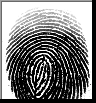

In [22]:
fingerprint = cv.imread('1.BMP', cv.IMREAD_GRAYSCALE)
show(fingerprint)

,
,

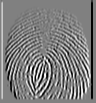
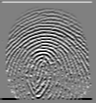

In [20]:
gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)
show(gx,gy)

Gx**2,Gy**2,Gradient magnitude
,,

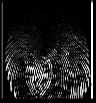
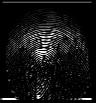
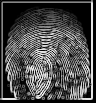

In [21]:
gx2, gy2 = gx**2, gy**2
gm = np.sqrt(gx2 + gy2)
show((gx2, 'Gx**2'), (gy2, 'Gy**2'), (gm, 'Gradient magnitude'))

Binarizing

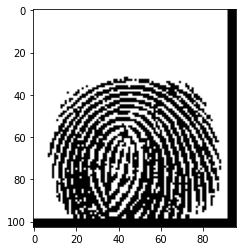

In [23]:
_, ridge_lines = cv.threshold(fingerprint, 32, 255, cv.THRESH_BINARY)
plt.imshow(cv.cvtColor(ridge_lines, cv.COLOR_RGB2BGR)) 

Thinning

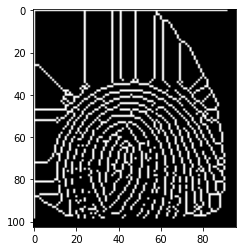

In [24]:
skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
plt.imshow(cv.cvtColor(skeleton, cv.COLOR_RGB2BGR)) 

Minutiae detection

In [25]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

In [26]:
# Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                     ])

In [27]:
# Create a lookup table that maps each byte value to the corresponding crossing number
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

In [28]:
# Skeleton: from 0/255 to 0/1 values
skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
# Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
# Apply the lookup table to obtain the crossing number of each pixel
cn = cv.LUT(cn_values, cn_lut)
# Keep only crossing numbers on the skeleton
cn[skeleton==0] = 0

In [29]:
# crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

In [30]:
print(minutiae)

[(24, 0, False), (37, 0, False), (41, 0, False), (48, 0, False), (58, 0, False), (91, 0, True), (58, 2, False), (61, 5, False), (70, 15, False), (0, 26, False), (80, 31, False), (48, 32, False), (42, 33, True), (69, 33, False), (47, 34, False), (49, 34, False), (25, 35, False), (38, 35, False), (54, 35, False), (69, 35, False), (24, 36, False), (64, 36, True), (82, 36, False), (24, 37, False), (15, 38, False), (23, 38, False), (63, 38, True), (67, 38, True), (73, 38, False), (62, 39, False), (84, 39, False), (15, 40, False), (17, 40, False), (28, 40, False), (75, 40, False), (19, 41, False), (70, 41, False), (14, 42, False), (30, 42, False), (32, 42, False), (68, 43, False), (77, 43, False), (17, 44, False), (34, 44, False), (79, 44, False), (15, 45, False), (33, 45, False), (56, 45, True), (70, 45, True), (75, 45, False), (20, 46, False), (0, 47, False), (15, 47, False), (21, 47, True), (35, 47, False), (41, 47, True), (54, 47, False), (58, 47, True), (71, 47, True), (82, 47, False), 

In [63]:
# Utility function to draw a set of minutiae over an image
def draw_minutiae(fingerprint, minutiae, termination_color = (255,0,0), bifurcation_color = (0,0,255)):
    res = cv.cvtColor(fingerprint, cv.COLOR_GRAY2BGR)
    
    for x, y, t, *d in minutiae:
        color = termination_color if t else bifurcation_color
        if len(d)==0:
            cv.drawMarker(res, (x,y), color, cv.MARKER_CROSS, 1)
        # else:
        #     cv.drawMarker(res, (x,y), color, cv.MARKER_CROSS, 1)
        else:
            d = d[0]
            ox = int(round(math.cos(d) * 3))
            oy = int(round(math.sin(d) * 3))
            # cv.circle(res, (x,y), 2, color, 1, cv.LINE_AA)
            cv.line(res, (x,y), (x+ox,y-oy), color, 1, cv.LINE_AA)        
    return res

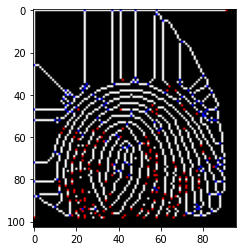

In [33]:
d = draw_minutiae(skeleton, minutiae)
plt.imshow(d)
# Blue - Bifurcation
# Red - Termination

Orientation of minutiae points

In [34]:
def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

In [36]:
r2 = 2**0.5 # sqrt(2)

# The eight possible (x, y) offsets with each corresponding Euclidean distance
xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

In [37]:
def follow_ridge_and_compute_angle(x, y, d = 8):
    px, py = x, y
    length = 0.0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None

In [39]:
# Utilities for angle arithmetics
def angle_abs_difference(a, b):
    return math.pi - abs(abs(a - b) - math.pi)

def angle_mean(a, b):
    return math.atan2((math.sin(a)+math.sin(b))/2, ((math.cos(a)+math.cos(b))/2))

In [55]:
minutiae_angle = []
for x, y, term in minutiae:
    d = None
    if term: # termination: simply follow and compute the direction        
        d = follow_ridge_and_compute_angle(x, y)
    else: # bifurcation: follow each of the three branches
        dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
        if len(dirs)==3: # only if there are exactly three branches
            angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1], d) for d in dirs]
            if all(a is not None for a in angles):
                a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                d = angle_mean(a1, a2)                
    if d is not None:
        minutiae_angle.append( (x, y, term, d) )

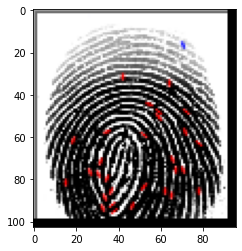

In [64]:
d=draw_minutiae(fingerprint, minutiae_angle)
plt.imshow(d)

In [53]:
print(minutiae_angle) # x,y,bool(isTermination), orientation(in radians)

[(24, 0, False, -0.7853981633974483), (91, 0, True, 3.141592653589793), (70, 15, False, -1.3005865766596045), (0, 26, False, -1.1581079015345275), (42, 33, True, 1.6207547225168393), (64, 36, True, 1.727398203776912), (56, 45, True, 2.9562447035940984), (58, 47, True, -0.8253768505207384), (71, 47, True, -0.9685089806599324), (58, 49, True, -1.0121970114513341), (71, 56, True, -1.1801892830972098), (33, 58, True, 0.4636476090008061), (19, 60, True, -1.8417431771333173), (53, 60, True, 2.4227626539681686), (79, 64, True, 2.173083672929861), (66, 72, True, 1.892546881191539), (31, 73, True, 1.2793395323170296), (67, 74, True, -1.7126933813990606), (26, 75, True, -1.2315037123408519), (30, 76, True, -1.2722973952087173), (71, 77, True, 1.8417431771333173), (34, 81, True, 1.299849476456476), (53, 82, True, -2.137525544318403), (15, 83, True, 1.4659193880646628), (78, 84, True, -1.460139105621001), (36, 87, True, 1.1071487177940904), (62, 87, True, 1.6233793884058383), (65, 89, True, 1.4288